# **Chap2：深度学习基础**

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input
from keras.models import Sequential
import numpy as np
from source.code import ch2
from source.code import utils
from matplotlib import pyplot as plt
from IPython import display

In [4]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
# utils.gpu_limitation_config(memory=12)

## **1 监测模型训练状态**

深度学习模型一大特点是**参数量众多**，一个模型的参数规模越大，其拟合能力就越强，模型在训练过程中就越容易出现**过拟合**

因此，我们需要时刻监测模型的训练状态，在**观察到过拟合现象后，及时停止模型训练，或者调整模型的训练策略**：
* 修改模型训练的超参数（学习率，批量大小等）
* 修改模型的结构，减少模型参数规模
* 引入正则化技巧

一种监测模型训练状态的办法，是以**迭代次数**`epochs`为横坐标，绘制下面的三条线：
* 模型**在训练集上的损失函数值**
  * 通常情况下，我们通过`SGD`极小化损失函数，这条线能够帮助我们监测极小化策略是否被正确执行，并判断模型训练是否收敛
* 模型**在训练集上的评估指标值**
  * 评估指标可能会和损失函数相同，也可能不同，它是用于衡量模型性能
* 模型**在验证集上的评估指标值**
  * 它用来和训练集评估指标做对比，我们比较二者之间的差距，判断模型是否出现了过拟合

我们可以定义一个动画类`Animator`来在训练过程中，动态调整和显示上面的三条线

In [2]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, xlim=None, ylim=None, legend=None,
                 xscale='linear', yscale='linear', fmts=('-', 'm--', 'g-.', 'r:'), 
                 nrows=1, ncols=1, figsize=(5, 3), title : str=None):
        """
        Parameters
        ----------
        xlabel, ylabel, xlim, ylim, xscale, yscale
            横，纵坐标轴相关设置
        legend : list of str
            图例
        title : str
            图标标题
        nrows, ncols, figsize
            子图行数和列数，图像画布大小
        fmts : tuple
            图中每条线的格式配置，例如`g-.`表示用绿色(`green`)绘制点划线`-.`
        """
        # 设置绘图相关信息
        def set_axes(ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend, title):
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_xscale(xscale)
            ax.set_yscale(yscale)
            ax.legend(legend)
            ax.set_title(title)
            ax.grid()
            plt.tight_layout()
        
        if legend is None:
            legend = []

        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
            legend = (legend,)
            fmts = (fmts,)
        else:
            self.axes = self.axes.flatten()
        # lambda 函数将配置参数的信息保存到 set_axes() 函数
        self.config_axes = lambda ax : \
            set_axes(self.axes[ax], xlabel, ylabel, xlim, ylim, xscale, yscale, legend[ax], title)
        self.X, self.Y = [None for _ in self.axes], [None for _ in self.axes]
        self.fmts = fmts # 初始化

    def add(self, x, y : list, ax : int=0):
        """
        在现有的图上添加新的点
        """
        # 如果 y 不是序列类型，就转换为列表
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y) # 共有 n 条线

        # 如果 x 不是序列类型，就转换为列表
        if not hasattr(x, "__len__"):
            x = [x] * n
        
        # 初始化 X
        if not self.X[ax]:
            self.X[ax] = [[] for _ in range(n)] 
        # 初始化 Y
        if not self.Y[ax]:
            self.Y[ax] = [[] for _ in range(n)] 
        
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[ax][i].append(a) # 添加横坐标
                self.Y[ax][i].append(b) # 添加纵坐标

        self.axes[ax].cla() # 清空画布
        for x, y, fmt in zip(self.X[ax], self.Y[ax], self.fmts[ax]):
            self.axes[ax].plot(x, y, fmt) # 绘制曲线
        
        self.config_axes(ax) # 配置画布
        display.display(self.fig) # 展示画布
        display.clear_output(wait=True) # 延迟清除

创建一个回归问题

$$
y = 0.05 + \sum_{i=1}^{d}0.01 x^{(i)} + \varepsilon,\quad \varepsilon\sim N(0,0.01^2)
$$

In [3]:
n_train, n_valid = 20, 100 # 训练集和验证集大小
input_size = 200
true_w, trub_b = tf.ones([input_size,1])*0.01, 0.05
# 生成训练集
x_train = tf.random.normal((n_train,input_size)) * 0.1
y_train = x_train @ true_w + trub_b + tf.random.normal((n_train,1),stddev=0.01)
# 生成验证集
x_valid = tf.random.normal((n_valid,input_size)) * 0.1
y_valid = x_valid @ true_w + trub_b + tf.random.normal((n_valid,1),stddev=0.01)

为了让过拟合更严重，这里我们仅使用极少的样本，而特征维度设置为`200`

接下来，我们定义一个最简单的**线性回归模型**，并在`train()`函数中，添加相应的动画接口，呈现模型的训练过程：
* 损失函数使用**均方误差函数**

In [4]:
class LinearRegression(tf.keras.Model):
    def __init__(self, input_dims : int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.W = tf.Variable(tf.random.normal([input_dims,1]))
        self.b = tf.Variable(tf.zeros((1,)))
    
    def call(self, inputs, training=None, mask=None):
        return inputs @ self.W + self.b

In [5]:
def train(model, X_train : tf.Tensor, y_train : tf.Tensor, X_valid : tf.Tensor, y_valid : tf.Tensor, 
          batch_size : int=32, epochs : int=200, lr : float=0.01, verbose : int=5):
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr) # 创建优化器
    mse = tf.keras.losses.MeanSquaredError() # 实例化损失函数

    animator = Animator(xlabel="Epochs",legend=["train loss","valid loss"],
                        yscale="linear",xlim=[0,epochs]) # 创建动画实例

    for epoch in range(epochs):
        # 使用 Tensorflow API 创建批量数据的生成器
        batch_data = tf.data.Dataset.from_tensor_slices((X_train,y_train)).\
            batch(batch_size=batch_size).shuffle(buffer_size=batch_size)
        
        for x_batch, y_batch in batch_data:
            # 跟踪梯度
            with tf.GradientTape() as tape:
                y_hat = model(x_batch)
                loss = mse(y_batch,y_hat)
            
            # 选取参数，计算梯度
            weights = model.trainable_variables
            grads = tape.gradient(loss,weights)
            optimizer.apply_gradients(zip(grads,weights)) # 直接调用优化器 API
        
        # 计算评估指标，添加到动画
        if epoch == 0 or (epoch+1)%verbose == 0: # 每 verbose 次更新一次
            y_train_hat = model(X_train)
            y_valid_hat = model(X_valid)

            train_loss = mse(y_train,y_train_hat).numpy()
            valid_loss = mse(y_valid,y_valid_hat).numpy()
            animator.add(epoch+1,[train_loss,valid_loss])
        
    return model

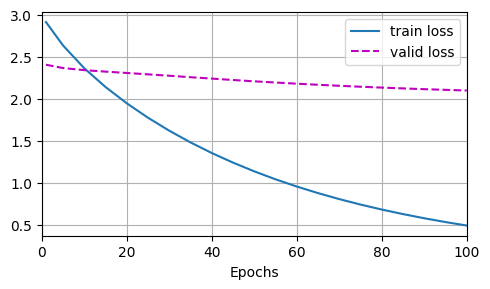

In [7]:
model = LinearRegression(input_dims=input_size)
model = train(model,x_train,y_train,x_valid,y_valid,batch_size=5,lr=0.01,epochs=100)

随着训练的进行，训练集损失在不断下降，而验证集损失没有下降，且与训练集损失之前的差距越来越大，这是**明显的过拟合信号**

我们将`Animator`类放入到`./source/code/utils.py`里，在之后的章节中可以直接导入这个模块

----

## **2 权重衰退**

### **2.1 权重衰退理论**

在训练**参数化机器学习模型**时， **权重衰减**（weight decay）是最广泛使用的正则化的技术之一，它通常也被称为 $L_2$ 正则化

模型参数的范数 $\|\Theta\|_2^2$ 可以**用于表示模型的复杂度**：
* 当参数全为0时，任何不同的输入都会得到相同的输出，我们认为此时模型是最简单的，复杂度 $\|\Theta\|_2^2 = 0$
* 参数 $\Theta$ 的绝对值越大，输入扰动带来的输出的变化程度越明显

要保证权重比较小，限制模型的复杂度，最常用方法是将其范数作为惩罚项加到最小化损失的问题中：

$$
\ell(\Theta) = \frac{1}{N}\sum_{i=1}^{N}L(y_i,f(x_i;\Theta)) + \lambda\cdot \|\Theta\|_2^2
$$

其中，$\lambda \geq 0$ 是正则化强度超参数，当 $\lambda = 0$ 时代表不进行正则化，当 $\lambda \to 0$ 时，我们会得到一个最简单的模型，即 $\Theta$ 所有分量全为0

这种使用参数的 $L_2$ 范数作为正则化项的模型，在统计中称为**岭回归（Ridge）**，除了 $L_2$ 范数，$L_1$ 范数也是一种常用的正则化范数

我们对为什么使用 $L_2$ 范数做补充说明：
* 使用 $L_2$ 范数的一个原因是它对权重的大分量施加了更大的惩罚，这使得我们的学习算法偏向于选择在大量特征上均匀分布权重的模型，在实践中，这可能**使它们对单个变量中的观测误差更为稳定**
* $L_1$ 惩罚会导致模型将权重集中在一小部分特征上（**稀疏惩罚**），而将其他权重清除为零，这称为**特征选择**（**feature selection**）

此外，我们从梯度下降更新的式子中，可以明白**权重衰退**名称的由来，注意此时的梯度计算有：
$$
\frac{\partial \ell(\Theta)}{\partial \Theta} = \frac{1}{N}\sum_{i=1}^{N}\frac{\partial L_i}{\partial \Theta} + 2\lambda\cdot \Theta
$$

梯度下降的迭代式为：
$$
\Theta_{k+1} = \Theta_{k} - \eta\cdot \left( \frac{1}{N}\sum_{i=1}^{N}\frac{\partial L_i}{\partial \Theta_k} + 2\lambda\cdot \Theta_k \right) = (1 - 2\eta\lambda)\cdot \Theta_k - \frac{\eta}{N}\sum_{i=1}^{N}\frac{\partial L_i}{\partial \Theta_k}
$$

相比之前的迭代更新公式，现在每次更新会在上一步参数 $\Theta_k$ 的基础上乘以一个**权重衰退因子** $(1-2\eta\lambda) < 1$，**这试图将权重的大小缩小到零**，这就是为什么这种方法有时被称为**权重衰减**

### **2.2 权重衰退实验**

**(1) 从零动手实现**

我们只需要定义一个函数计算参数的 $L_2$ 范数，然后将这一部分加入损失函数即可

In [8]:
def l2_penalty(weights):
    return tf.reduce_sum(tf.pow(weights,2))

重新定义训练函数，只需要在损失的计算部分加入正则化项，定义一个参数`lamda`控制正则化超参数

In [9]:
def train_weights_decay(model, X_train : tf.Tensor, y_train : tf.Tensor, X_valid : tf.Tensor, y_valid : tf.Tensor, 
                        lamda : float=1, batch_size : int=32, epochs : int=200, lr : float=0.01, verbose : int=5):
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr) # 创建优化器
    mse = tf.keras.losses.MeanSquaredError() # 实例化损失函数

    animator = Animator(xlabel="Epochs",legend=["train loss","valid loss"],
                        yscale="linear",xlim=[0,epochs]) # 创建动画实例

    for epoch in range(epochs):
        # 使用 Tensorflow API 创建批量数据的生成器
        batch_data = tf.data.Dataset.from_tensor_slices((X_train,y_train)).\
            batch(batch_size=batch_size).shuffle(buffer_size=batch_size)
        
        for x_batch, y_batch in batch_data:
            # 跟踪梯度
            with tf.GradientTape() as tape:
                y_hat = model(x_batch)
                loss = mse(y_batch,y_hat) + lamda * l2_penalty(model.W) # 增加正则化项
            
            # 选取参数，计算梯度
            weights = model.trainable_variables
            grads = tape.gradient(loss,weights)
            optimizer.apply_gradients(zip(grads,weights)) # 直接调用优化器 API
        
        # 计算评估指标，添加到动画
        if epoch == 0 or (epoch+1)%verbose == 0: # 每 verbose 次更新一次
            y_train_hat = model(X_train)
            y_valid_hat = model(X_valid)

            train_loss = mse(y_train,y_train_hat).numpy()
            valid_loss = mse(y_valid,y_valid_hat).numpy()
            animator.add(epoch+1,[train_loss,valid_loss])
        
    return model

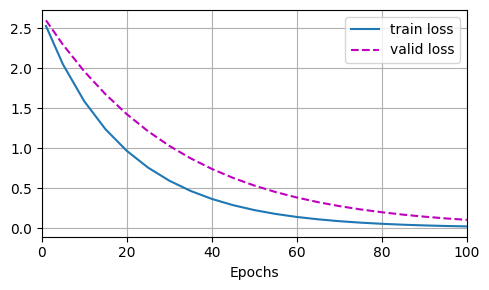

In [10]:
model = LinearRegression(input_dims=input_size)
model = train_weights_decay(model,x_train,y_train,x_valid,y_valid,lamda=0.2,batch_size=5,lr=0.01,epochs=100)

可以观察到，随着训练进行，**训练集和测试集上的损失都在以相同的程度下降，过拟合得到了缓解**

**(2) 使用API**

权重衰退是一种非常常用的正则化技术，对于常用的技术，几乎都已经被整合到各个深度学习框架中

**Tensorflow允许用户在定义计算层的时候，就指定模型使用的正则化项**

In [11]:
class LinearRegressionAPI(tf.keras.Model):
    def __init__(self, lamda : float=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dense = Dense(1,kernel_regularizer=tf.keras.regularizers.l2(l2=lamda)) # 指定 kernel 的正则化器
    
    def call(self, inputs, training=None, mask=None):
        return self.dense(inputs)

然后，我们可以使用`model.losses`来访问这些正则化的损失，将它们加入到损失函数的计算中

In [12]:
def train_weights_decay_API(model, X_train : tf.Tensor, y_train : tf.Tensor, X_valid : tf.Tensor, y_valid : tf.Tensor, 
                            batch_size : int=32, epochs : int=200, lr : float=0.01, verbose : int=5):
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr) # 创建优化器
    mse = tf.keras.losses.MeanSquaredError() # 实例化损失函数

    animator = Animator(xlabel="Epochs",legend=["train loss","valid loss"],
                        yscale="linear",xlim=[0,epochs]) # 创建动画实例

    for epoch in range(epochs):
        # 使用 Tensorflow API 创建批量数据的生成器
        batch_data = tf.data.Dataset.from_tensor_slices((X_train,y_train)).\
            batch(batch_size=batch_size).shuffle(buffer_size=batch_size)
        
        for x_batch, y_batch in batch_data:
            # 跟踪梯度
            with tf.GradientTape() as tape:
                y_hat = model(x_batch)
                loss = mse(y_batch,y_hat) + model.losses # 增加正则化项
            
            # 选取参数，计算梯度
            weights = model.trainable_variables
            grads = tape.gradient(loss,weights)
            optimizer.apply_gradients(zip(grads,weights)) # 直接调用优化器 API
        
        # 计算评估指标，添加到动画
        if epoch == 0 or (epoch+1)%verbose == 0: # 每 verbose 次更新一次
            y_train_hat = model(X_train)
            y_valid_hat = model(X_valid)

            train_loss = mse(y_train,y_train_hat).numpy()
            valid_loss = mse(y_valid,y_valid_hat).numpy()
            animator.add(epoch+1,[train_loss,valid_loss])
        
    return model

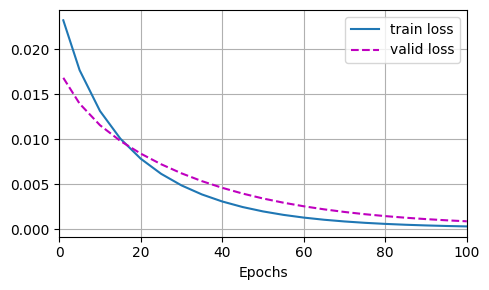

In [13]:
# 创建模型，训练模型
model = LinearRegressionAPI(lamda=0.2)
model = train_weights_decay_API(model,x_train,y_train,x_valid,y_valid,batch_size=5,lr=0.01,epochs=100)

----

## **3 暂退法Dropout**

### **3.1 随机扰动的稳健性**

我们希望一个好的模型，**在没有见过的数据上拥有较强的泛化能力**，经典的泛化理论认为，为了缩小训练集和测试集性能之间的差距，应该**以简单模型为目标**，鼓励简单模型，减少模型的复杂度，例如上一节讨论的 $L_2$ 正则化，我们用 $\|\Theta\|_2^2$ 度量模型的复杂度

另一个角度考虑模型的泛化性，我们希望**模型拟合得到的决策函数不应该对输入的微小变化敏感**，例如在图像分类任务中，我们预计向图片中添加一些随机噪声，应该几乎不影响模型的判断结果， 1995年，克里斯托弗·毕晓普证明了**具有输入噪声的训练等价于Tikhonov正则化**，这项工作用数学证实了“**要求函数光滑**”和“**要求函数对输入的随机噪声具有适应性**”之间的联系

因此，另一类模型正则化的手段，**是在模型训练的过程中，为模型引入随机性**，如果**模型在持续的随机扰动中依然能拟合得到一个良好的决策函数**，我们可以认为此时模型掌握的是数据本质的特征，而不是通过样本独有的噪声来标识每个样本，即模型没有过拟合

这种引入随机性的思想不只有深度学习中存在，在传统机器学习中也被大量使用，例如决策树和随机森林中的**样本随机采样**和**特征随机采样**

2014年，斯里瓦斯塔瓦等人就如何将毕晓普的想法应用于网络的内部层提出了一个想法：**在训练过程中，他们建议在计算后续层之前向网络的每一层注入噪声**。因为当训练一个有多层的深层网络时，注入噪声只会在输入-输出映射上增强平滑性

关键的挑战就是**如何注入这种噪声**。一种想法是以一种**无偏（unbiased）的方式注入噪声**。 这样在固定住其他层时，每一层的期望值等于没有噪音时的值，毕晓普将高斯噪声添加到线性模型的输入中，在每次训练迭代中，他将从均值为零的分布 $\varepsilon\sim N(0,\sigma^2)$ 采样噪声添加到输入 $\boldsymbol{x}$，从而产生扰动点：
$$
\boldsymbol{x}^{'} = \boldsymbol{x} + \varepsilon,
$$
这种扰动满足无偏性：$\mathbb{E}(\boldsymbol{x}^{'}) = \boldsymbol{x}$

### **3.2 Dropout的逻辑**

深度神经网络常用的**暂退法**（**Dropout**），同样在前向传播过程中，计算每一内部层的同时注入噪声，这已经成为训练神经网络的常用技术

这种方法之所以被称为暂退法，因为我们从表面上看，是**在训练过程中丢弃（drop out）一些神经元**。在整个训练过程的每一次迭代中，标准暂退法包括**在计算下一层之前将当前层中的一些节点置零**

在标准Dropout正则化中，通过按保留（未丢弃）的节点的分数**进行规范化**来消除每一层的偏差，得到无偏估计，简单来说，**每个中间层激活值** $h$ **以丢弃概率** $p$ **由随机变量** $h'$ **替换**：
$$
h' = \left\{
\begin{array}{ll}
0, & \text{概率为 }p \\
h/(1-p), & \text{其他情况.} \\
\end{array}
\right.
$$

这样，对于每个激活值 $h$，满足无偏性 $\mathbb{E}(h')=h$

下图展示了Dropout机制，在模型训练时的行为

<img src="./source/Chap2/Dropout.png" width=900>

从Dropout的结果看，我们可以当作每次Dropout操作只会保留该层神经元的一个子集，因此**下一层的输出结果不再依赖于被丢弃的那些神经元**，由于**在这一轮推理中被丢弃神经元没有参与计算，因此被丢弃神经元的梯度在该轮计算执行反向传播时也会消失**，它们的权重在该轮不会被更新

最后，对Dropout补充说明以下几点：
* **每次前向计算时**使用Dropout丢弃的神经元是随机的，不是固定的
* 通常，我们**在测试阶段，即模型预测阶段不使用Dropout策略**，给定一个训练好的模型和一个待预测的样本，我们不会丢弃任何节点
* 可以简单理解为**Dropout策略使得模型在训练时，每次只更新部分计算节点的参数**

你也可以将Dropout的行为类别为决策树在进行特征的随机选择，每一轮梯度更新只使用隐藏层的部分神经元

### **3. Dropout实现**

**(1) 从零动手实现**

可以将Dropout视为计算中的一个层，它作用于激活函数之后

In [14]:
def dropout_layer(X : tf.Tensor, dropout : float=0.5):
    assert 0 <= dropout <= 1
    # 如果 dropout = 1，所有元素置 0
    if dropout == 1:
        return tf.zeros_like(X)
    # 如果 dropout = 0, 等价于不使用 Dropout
    if dropout == 0:
        return X
    
    # 创建一个 mask 掩码，通过生成 [0,1] 的均匀随机数
    # 将随机数小于 1 - dropout 的元素保留
    mask = tf.random.uniform(shape=X.shape, minval=0, maxval=1) < (1 - dropout)
    mask = tf.cast(mask, dtype=tf.float32) # 将 True / False 转换为 1 / 0 浮点矩阵
    return (mask * X) / (1 - dropout)

In [15]:
X = tf.reshape(tf.range(16, dtype=tf.float32), (2, 8))
print("X: ",X)
print("dropout = 0.0: ",dropout_layer(X, 0.))
print("dropout = 0.5: ",dropout_layer(X, 0.5))
print("dropout = 1.0: ",dropout_layer(X, 1.))

X:  tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
dropout = 0.0:  tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
dropout = 0.5:  tf.Tensor(
[[ 0.  0.  0.  6.  0.  0.  0. 14.]
 [ 0.  0.  0. 22.  0. 26.  0.  0.]], shape=(2, 8), dtype=float32)
dropout = 1.0:  tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


接下来，定义模型，并引入Dropout层

In [16]:
class LinearRegressionDropout(tf.keras.Model):
    def __init__(self, num_hiddens : int=64, dropout : float=0.2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dense1 = Dense(num_hiddens,activation='tanh')
        self.dense2 = Dense(1)
        self.dropout = dropout
    
    def call(self, inputs, training=None, mask=None):
        x = self.dense1(inputs)
        # 只有在训练模型时才使用dropout
        if training:
            x = dropout_layer(x,self.dropout)
        return self.dense2(x)

In [17]:
def train_dropout(model, X_train : tf.Tensor, y_train : tf.Tensor, X_valid : tf.Tensor, y_valid : tf.Tensor, 
                  batch_size : int=32, epochs : int=200, lr : float=0.01, verbose : int=5):
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr) # 创建优化器
    mse = tf.keras.losses.MeanSquaredError() # 实例化损失函数

    animator = Animator(xlabel="Epochs",legend=["train loss","valid loss"],
                        yscale="linear",xlim=[0,epochs]) # 创建动画实例

    for epoch in range(epochs):
        # 使用 Tensorflow API 创建批量数据的生成器
        batch_data = tf.data.Dataset.from_tensor_slices((X_train,y_train)).\
            batch(batch_size=batch_size).shuffle(buffer_size=batch_size)
        
        for x_batch, y_batch in batch_data:
            # 跟踪梯度
            with tf.GradientTape() as tape:
                y_hat = model(x_batch,training=True) # 训练时，使用 Dropout
                loss = mse(y_batch,y_hat)
            
            # 选取参数，计算梯度
            weights = model.trainable_variables
            grads = tape.gradient(loss,weights)
            optimizer.apply_gradients(zip(grads,weights)) # 直接调用优化器 API
        
        # 计算评估指标，添加到动画
        if epoch == 0 or (epoch+1)%verbose == 0: # 每 verbose 次更新一次
            y_train_hat = model(X_train)
            y_valid_hat = model(X_valid)

            train_loss = mse(y_train,y_train_hat).numpy()
            valid_loss = mse(y_valid,y_valid_hat).numpy()
            animator.add(epoch+1,[train_loss,valid_loss])
        
    return model

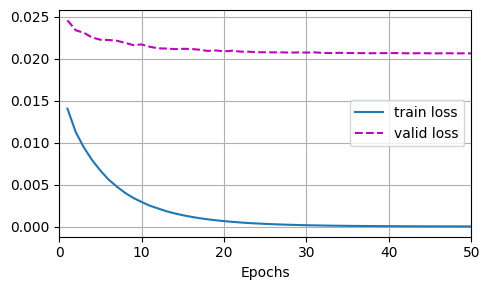

In [18]:
model = LinearRegressionDropout(dropout=0)
model = train_dropout(model,x_train,y_train,x_valid,y_valid,batch_size=4,lr=0.05,epochs=50,verbose=1)

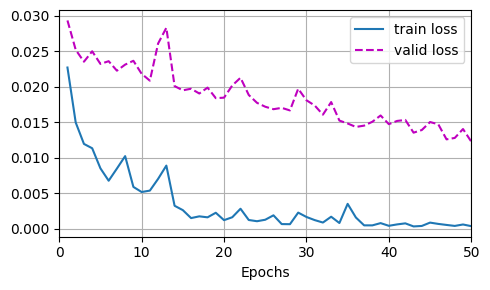

In [19]:
model = LinearRegressionDropout(dropout=0.5)
model = train_dropout(model,x_train,y_train,x_valid,y_valid,batch_size=4,lr=0.05,epochs=50,verbose=1)

**(2) 使用API**

Dropout现在作为深度学习的基本计算层，也可以直接使用API来使用

In [20]:
class LinearRegressionDropoutAPI(tf.keras.Model):
    def __init__(self, num_hiddens : int=64, dropout : float=0.2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dense1 = Dense(num_hiddens,activation='tanh')
        self.dense2 = Dense(1)
        self.dropout1 = tf.keras.layers.Dropout(rate=dropout)
    
    def call(self, inputs, training=None, mask=None):
        x = self.dense1(inputs)
        x = self.dropout1(x)  # API 只会在训练的时候启用 Dropout
        return self.dense2(x)

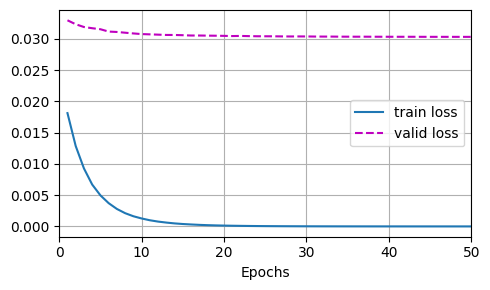

In [21]:
model = LinearRegressionDropoutAPI(dropout=0)
model = train_dropout(model,x_train,y_train,x_valid,y_valid,batch_size=4,lr=0.05,epochs=50,verbose=1)

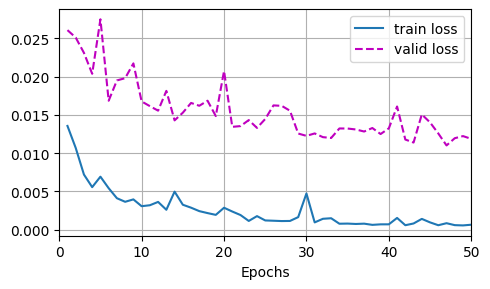

In [22]:
model = LinearRegressionDropoutAPI(dropout=0.5)
model = train_dropout(model,x_train,y_train,x_valid,y_valid,batch_size=4,lr=0.05,epochs=50,verbose=1)

**Dropout因为实现简单，几乎不增加额外的计算负担，因此是深度学习最常用的正则化技术**

----

## **4 数值稳定性和参数初始化**

### **4.1 梯度消失和梯度爆炸**

考虑一个具有 $L$ 层，输入 $\boldsymbol{x}$ 到输出 $\boldsymbol{o}$ 的神经网络，每一层 $l$ 由变换 $f_l$ 定义：
$$
\boldsymbol{h}^{(l)} = f_l(\boldsymbol{h}^{(l-1)})
$$

变换的参数记录为权重 $\boldsymbol{W}^{(l)}$，则：
$$
\boldsymbol{o} = f_L\circ \cdots \circ f_1(\boldsymbol{x})
$$

此时，输出关于任何一组参数 $\boldsymbol{W}^{(l)}$ 的梯度为：

$$
\partial_{\boldsymbol{W}^{(l)}} \boldsymbol{o} = \partial_{\boldsymbol{h}^{(L-1)}} \boldsymbol{h}^{(L)}\times \cdots \times 
\partial_{\boldsymbol{h}^{(l)}} \boldsymbol{h}^{(l+1)}\times \partial_{\boldsymbol{W}^{(l)}} \boldsymbol{h}^{(l)}
$$

该梯度是 $L-l + 1$ 个矩阵的乘积，当层数 $L$ 比较大时，该**梯度值很容易受到数值下溢问题的影响**

**在模型初始化阶段，各个梯度矩阵具有各种各样的特征值，它们可能很小也可能很大，因此它们的累乘可能非常大，也可能非常小**

不稳定的梯度带来的风险不只是在数值表示，也威胁到优化算法的稳定性，最主要的两种问题即：**梯度消失**和**梯度爆炸**

**(1) 梯度消失**

当梯度矩阵的元素取值较小，经过多轮累乘后，**参数更新过小，在每次更新时几乎不会移动，导致模型无法学习**，这就是**梯度消失**

Sigmoid函数是深度学习早期人们最喜欢，最常使用的激活函数，因为它激活类型类似于人类的神经元（完全激活和完全抑制），但**使用Sigmoid激活函数容易导致梯度消失问题**，注意Sigmoid函数及其导数的图像

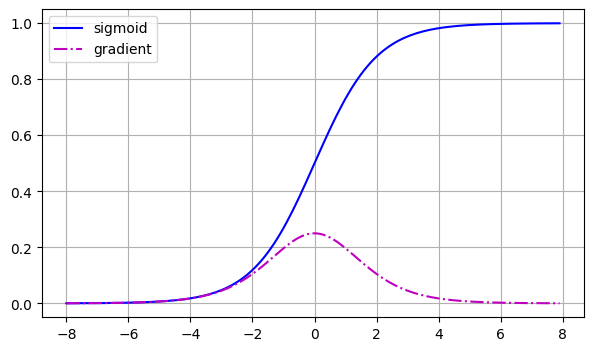

In [25]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1))
with tf.GradientTape() as tape:
    y = tf.nn.sigmoid(x)
grads = tape.gradient(y,x)
# 绘图
fig = plt.figure(figsize=(7,4))
plt.plot(x.numpy(), y.numpy(), "b-", label="sigmoid")
plt.plot(x.numpy(), grads.numpy(), "m-.", label="gradient")
plt.grid()
plt.legend()

从上图可以看到：
* 当Sigmoid函数的**输入偏大或偏小时，它的梯度都会消失**
* 当反向传播通过许多层时，除非我们在刚刚好的地方，这些地方Sigmoid函数的输入 $\boldsymbol{x}$ 接近于零，否则**整个乘积的梯度可能会消失**
* 当我们的网络有很多层时，除非我们很小心，否则**梯度可能在某一层被切断**

事实上，这个问题曾经困扰着深度网络的训练。 因此，**更稳定的ReLU系列函数已经成为更好的默认选择**

在此，简单介绍除了Sigmoid之外的几个常见的激活函数

* **tanh激活函数**

$$
\text{tanh}(x) = \frac{\text{sinh}(x)}{\text{cosh}(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

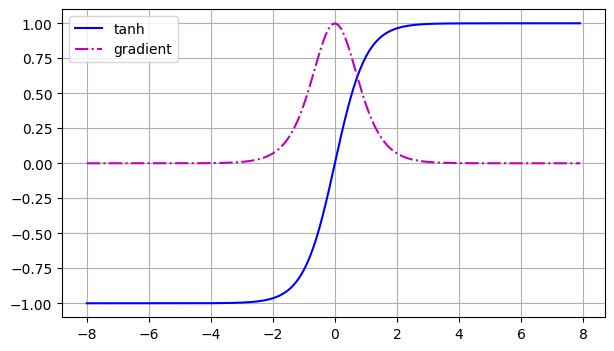

In [26]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1))
with tf.GradientTape() as tape:
    y = tf.nn.tanh(x)
grads = tape.gradient(y,x)
# 绘图
fig = plt.figure(figsize=(7,4))
plt.plot(x.numpy(), y.numpy(), "b-", label="tanh")
plt.plot(x.numpy(), grads.numpy(), "m-.", label="gradient")
plt.grid()
plt.legend()

**tanh激活函数的形态与Sigmoid非常相似**，这类激活函数称为**类Sigmoid函数**，tanh能够将函数值映射到 $[-1,1]$ 范围内，在**基于神经网络的偏微分方程求解算法中，它是常用的激活函数**，它和Sigmoid函数都容易出现**梯度消失**问题（或者称为**梯度弥散**问题，即当输入偏大 / 偏小时，梯度值趋于0）

* **ReLU激活函数**

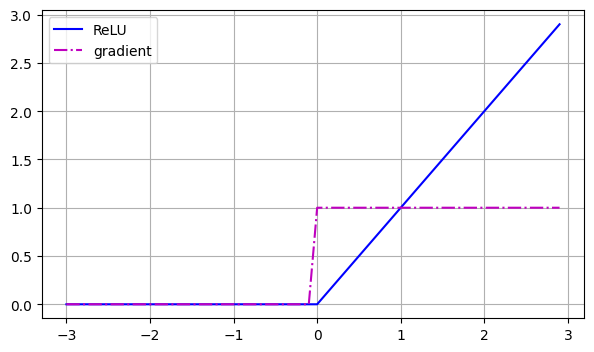

In [27]:
x = tf.Variable(tf.range(-3.0, 3.0, 0.1))
with tf.GradientTape() as tape:
    y = tf.nn.relu(x)
grads = tape.gradient(y,x)
# 绘图
fig = plt.figure(figsize=(7,4))
plt.plot(x.numpy(), y.numpy(), "b-", label="ReLU")
plt.plot(x.numpy(), grads.numpy(), "m-.", label="gradient")
plt.grid()
plt.legend()

**ReLU函数又被称为线性整流函数**，它在 $x > 0$ 时做恒等映射，在 $x < 0$ 时将值截断为0，因此ReLU激活函数可以表示为：
$$
\text{ReLU}(x) = \mathbb{I}(x > 0)\cdot x
$$

ReLU激活函数是现在深度学习模型最常用的激活函数，因为他最显著的两个优点：
* **无需像Sigmoid中指数算子一样的复杂非线性运算**，不会给模型带来额外的计算负担
* 在 $x > 0$ 时梯度值恒定等于1，不会出现梯度消失的问题

可能会注意到**ReLU在** $x = 0$ **处不可导**，但这不用担心，我们**只需要激活函数几乎处处可导即可**，因为样本恰好使得 $x = 0$ 的概率为0，即使出现了 $x = 0$，只需要**用这一点的单侧导数定义即可**

* **LeakyReLU激活函数**

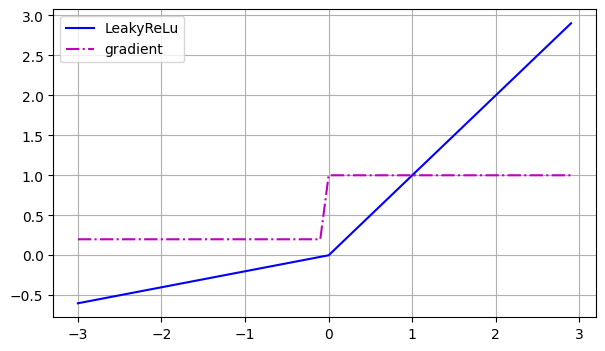

In [28]:
x = tf.Variable(tf.range(-3.0, 3.0, 0.1))
with tf.GradientTape() as tape:
    y = tf.nn.leaky_relu(x,alpha=0.2)
grads = tape.gradient(y,x)
# 绘图
fig = plt.figure(figsize=(7,4))
plt.plot(x.numpy(), y.numpy(), "b-", label="LeakyReLu")
plt.plot(x.numpy(), grads.numpy(), "m-.", label="gradient")
plt.grid()
plt.legend()

**ReLU在优化算法运行时可能会出现神经元死亡**的问题，因为在 $x < 0$ 的一段梯度值全为0，如果一次不那么好的初始化，可能**致使大量的参数都小于0，最终模型更新停止，即神经元死亡**

**LeakyReLU**是对**ReLU**的改进，它在 $x < 0$ 时施加一个线性变换 $ax$，使得 $x < 0$ 时的梯度部位0：
$$
\text{LeakyReLU}(x;a) = \left\{
\begin{array}{ll}
x, & x > 0,\\
ax, & x \leq 0 \\
\end{array}
\right.\quad a\ne 1
$$

如果**让LeakyReLU中的超参数** $a$ **也加入模型的学习（即参与梯度下降更新），就变为了参数化ReLU**，即**PReLu激活函数**

* **Swish激活函数**

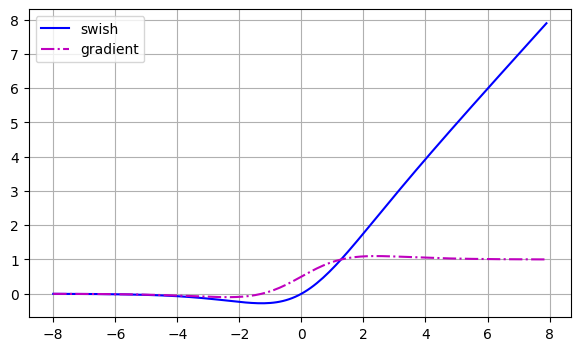

In [29]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1))
with tf.GradientTape() as tape:
    y = tf.nn.swish(x)
grads = tape.gradient(y,x)
# 绘图
fig = plt.figure(figsize=(7,4))
plt.plot(x.numpy(), y.numpy(), "b-", label="swish")
plt.plot(x.numpy(), grads.numpy(), "m-.", label="gradient")
plt.grid()
plt.legend()

Swish激活函数的表达式为：
$$
\text{Swish}(x) = x\cdot \text{Sigmoid}(x)
$$

可以看到，它是一个**形态长得像ReLU的完全可微的激活函数，它具有与ReLU相似的激活性质**

总之，激活函数种类繁多，但最常用的还是`sigmoid`, `tanh`和`  ReLU`，在其他帖子，论文中见到陌生的激活函数只需要查找了解其定义即可，**不同人的实验中使用各种不同的激活函数往往是为了取得更好的数值稳定性**

**(2) 梯度爆炸**

当梯度矩阵的元素取值较大，经过多轮累乘后，**参数更新过大，破坏了模型的稳定收敛**，这就是**梯度爆炸**

我们生成50个高斯随机矩阵，并将它们与某个初始矩阵相乘，对于方差 $\sigma^2=1$，这些乘积将产生梯度爆炸的效果

In [30]:
M = tf.random.normal((4, 4))
print('一个矩阵 \n', M.numpy())
for i in range(50):
    M = tf.matmul(M, tf.random.normal((4, 4))) # 模拟梯度爆炸的累乘过程

print('乘以50个矩阵后\n', M.numpy())

一个矩阵 
 [[ 0.19625247  0.13123208 -0.41565073  0.85578966]
 [-1.0193715   0.87772197  1.0030288  -0.70860434]
 [ 0.3994135   0.1641793  -0.62063193  1.2311672 ]
 [ 0.8723633   1.3431405   0.21776652 -0.59773284]]
乘以50个矩阵后
 [[-1.2295461e+12 -2.7792984e+12  3.7120807e+12 -1.7752400e+12]
 [ 2.4345696e+12  5.5031292e+12 -7.3500957e+12  3.5150532e+12]
 [-1.9232252e+12 -4.3473127e+12  5.8063475e+12 -2.7767871e+12]
 [-1.2460952e+12 -2.8167449e+12  3.7620789e+12 -1.7991540e+12]]


**当这种情况是由于深度网络的初始化所导致时，我们没有机会让梯度下降类算法收敛**，模型经过几次更新后很快出现`NaN`或者**数值溢出**

### **4.2 参数初始化和Xavier初始化**

解决，或者说减轻梯度消失和梯度爆炸的一种方法是进行适当的**参数初始化**，在算法优化期间的一切技巧和正则化手段也能进一步提高深度学习算法训练的稳定性，在前面的部分中，我们使用正态分布来初始化权重。**对于规模不太大，层数不太深的中等难度问题，正态随机初始化是有效的**

**没有非线性激活**的全连接层输出 $o_i$ 具有表达式：

$$
o_i = \sum_{j=1}^{n_{in}} w_{ij}x_j
$$

其中，$n_{in}$ 表示这一层的输入神经元个数，权重 $w_{ij}$ 都是从同一分布中独立抽取的，**假设该分布具有零均值和方差** $\sigma^2$，注意，我们**不要求分布是正态分布**，只要求分布的均值和方差存在

下面，我们假设输入层 $x_j$ 具有零均值，方差为 $\gamma^2$，并且输入层 $x_j$ 独立于参数 $w_{ij}$，则我们可以计算该层输出 $o_i$ 的均值和方差：

$$
\begin{array}{rcl}
\mathbb{E}[o_i] & = & \displaystyle{ \sum_{j=1}^{n_{in}} \mathbb{E}[w_{ij}x_j] } \\
& = & \displaystyle{ \sum_{j=1}^{n_{in}} \mathbb{E}[w_{ij}]\cdot \mathbb{E}[x_j] } \\
& = & 0,
\end{array}
$$

$$
\begin{array}{rcl}
\text{Var}[o_i] & = & \displaystyle{ \mathbb{E}[o_i^2] - \left(\mathbb{E}[o_i] \right)^2 } \\
& = & \displaystyle{ \sum_{j=1}^{n_{in}} \mathbb{E}[w_{ij}^2]\cdot \mathbb{E}[x_j]^2 } \\
& = & n_{in}\sigma^2\gamma^2.
\end{array}
$$

Xavier的想法是，**为了维护数值稳定性，该层输入的方差到输出结果的方差应该保持一致**，从上面的推导来看，保持方差不变的一种方法是设置：
$$
n_{in}\sigma^2 = 1
$$

上述推导是从前向计算的角度导出的，而**参数更新还需要考虑反向传播过程**，反向传播过程，我们面临类似的数值稳定性问题，此时**权重的累乘顺序和前向计算相反，梯度从更靠近输出的层开始传播到最开始的输入层**

使用与前向传播相同的推断，在反向传播时，为了保证该层输入和输出的方差一致，我们需要 $n_{out}\sigma^2 = 1$，否则梯度的方差可能会因数值不稳定而增大，其中 $n_{out}$ 是该层的输出神经元的个数

当 $n_{in}\ne n_{out}$ 时（事实上，大部分情况下如此），我们无法同时满足：
$$
n_{in}\sigma^2 = 1, \quad n_{out}\sigma^2 = 1
$$

**Xavier的解决思路是考虑平均意义下的相等**，即：
$$
\frac{1}{2}(n_{in} + n_{out})\sigma^2 = 1\quad \text{等价于}\quad \sigma = \sqrt{\frac{2}{n_{in} + n_{out}}}
$$

至此，我们得到了目前标准且最实用的Xavier初始化方案，它以其提出者(Glorot and Bengio, 2010)第一作者的名字命名，通常，Xavier初始化从均值为零，方差 $\sigma^2$：
$$
\sigma^2 = \frac{2}{n_{in} + n_{out}}
$$
的正态分布中采样权重，也有的实现是从均匀分布中抽取权重，只要保证均匀分布的方差等于 $\sigma^2$ 即可：
$$
U\left( -\frac{6}{n_{in} + n_{out}}, \frac{6}{n_{in} + n_{out}} \right)
$$

尽管上述的推导是在**没有非线性激活**的条件下导出的，而这种假设在深度神经网络几乎不满足，但**Xavier初始化方法在实践中证明是非常有效的**

最后，针对Xavier初始化做一些补充说明：
* Xavier初始化只需要该层输入维度和输出维度（即下一层的输入维度）就可以确定初始化方案
* 上面的介绍仅仅触及了现代参数初始化方法的皮毛，深度学习框架通常实现十几种不同的初始化方法，请根据使用需求进行选择，另外一种有名的初始化方法是Kaiming初始化（或者叫He初始化，这是Kaiming He，何凯明在2015年的论文中提出的初始化方法）
* `Tensorflow`**框架全局默认使用Xavier初始化方案**，我们不需要额外声明或设置，但**有一些深度学习框架**（例如`Pytorch`）**没有默认采用该初始化方案**，需要用户手动进行参数初始化方案的配置

例如，当使用`Dense?`查看全连接层的说明文档时，`kernel_initializer`就是参数初始化方案参数，**默认使用Xavier均匀分布初始化**

```python
Init signature:
Dense(
    units,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs,
)
```

可以使用`tf.keras.initializers`来使用不同的参数初始化方案

----

### **练习**

1. 在权重衰退中，可以尝试更改不同的正则化参数 $\lambda$，然后绘制训练集损失和验证集损失随着 $\lambda$ 的变化情况，你应该可以观察到过拟合，欠拟合现象

2. 在某一个固定的验证数据集上调整，寻找最优的权重衰退正则化超参数 $\lambda$ 会**造成另一种过拟合**，解释这里存在的过拟合问题

3. 在使用keras的`Dropout()`层训练模型时，比较调用模型的`call()`方法时，设置`training = True`和不设置`training`参数的结果

4. 查阅相关资料，简单说说Kaiming初始化是如何进行的